In [79]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir, load_yaml
from aimanager.utils.array_to_df import using_multiindex, add_labels
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = 'simple_6'

folder = f'../../data/manager_v3/{run}'

train_folder = os.path.join(folder, 'metrics')
merge_file = os.path.join(folder, 'metrics.parquet')
model_folder = os.path.join(folder, 'model')

plot_folder = f'plots/{run}'

make_dir(plot_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# if not os.path.isfile(merge_file):
#     dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
#     df = pd.concat(dfs)
#     df.to_parquet(merge_file)
# else:
#     df = pd.read_parquet(merge_file)
dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
df = pd.concat(dfs)

In [81]:
df.columns

Index(['memory_episodes', 'job_id', 'round_number', 'sampling', 'update_step',
       'metric', 'value'],
      dtype='object')

In [82]:
non_labels = ['round_number', 'sampling', 'update_step', 'metric', 'value', 'job_id']

labels = [c for c in df.columns if c not in non_labels]


In [83]:
df['metric'].unique()

array(['punishments', 'contributions', 'common_good',
       'contributor_payoff', 'manager_payoff', 'next_reward', 'q_min',
       'q_max', 'q_mean', 'loss'], dtype=object)

In [84]:
df[df['sampling'] == 'greedy']

,memory_episodes,job_id,round_number,sampling,update_step,metric,value
16,100,memory_episodes_100,0,greedy,0,punishments,15.000001
17,100,memory_episodes_100,1,greedy,0,punishments,15.000001
18,100,memory_episodes_100,2,greedy,0,punishments,16.098001
19,100,memory_episodes_100,3,greedy,0,punishments,15.270000
20,100,memory_episodes_100,4,greedy,0,punishments,15.000001
...,...,...,...,...,...,...,...
7995,1000,memory_episodes_1000,11,greedy,480,loss,NaN
7996,1000,memory_episodes_1000,12,greedy,480,loss,NaN
7997,1000,memory_episodes_1000,13,greedy,480,loss,NaN
7998,1000,memory_episodes_1000,14,greedy,480,loss,NaN


In [103]:
import statsmodels.formula.api as smf
w = (
    (df['metric'] == 'common_good') &
    (df['sampling'] == 'greedy')
)
dfs = df[w].copy()
w_max = (dfs['update_step'] == dfs['update_step'].max())
dfs = dfs[w_max].copy()

for l in labels:
    dfs[l] = dfs[l].astype(str)


label_ref = {
    'eps': '0.1',
    'gamma': '1.0',
    'lr': '3.e-4',
}


label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]


results = smf.glm(f"value ~ {'+'.join(label_str)}", data=dfs).fit()
results_df = results.summary2().tables[1]

# print('metric accuracy - positive coef -> better')
# results_df[results_df['P>|z|'] < 0.25].sort_values('P>|z|')
results_df

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,17.084748,0.513588,33.265453,1.220428e-242,16.078133,18.091363
memory_episodes[T.1000],-0.205378,0.726324,-0.282764,7.773579e-01,-1.628946,1.218190


In [86]:
label_str

['memory_episodes']

In [87]:
df['sampling'].unique()

array(['eps-greedy', 'greedy'], dtype=object)

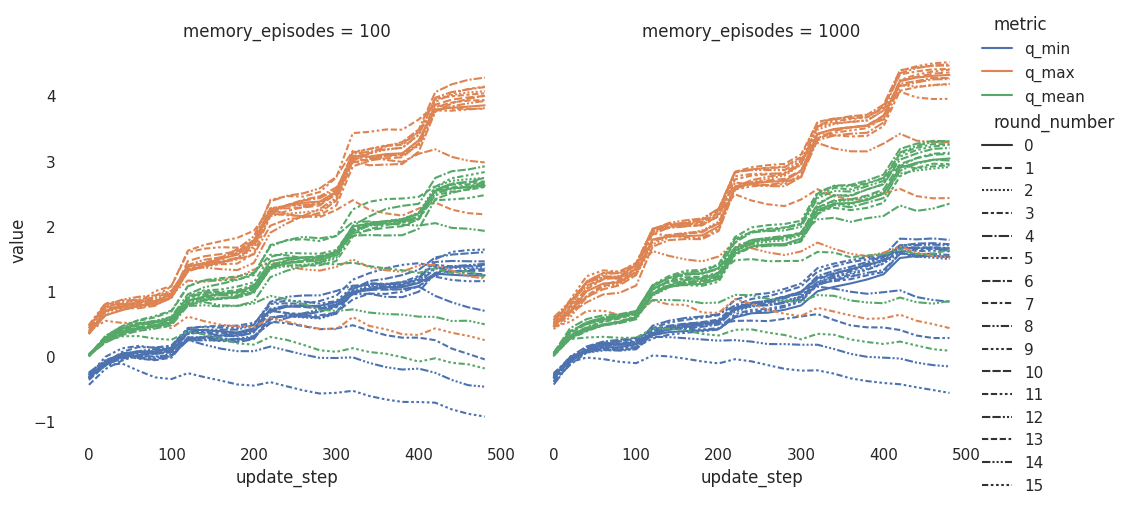

In [88]:
selection = {'eps': 0.2, 'gamma': 1.0, 'lr': '1.e-4', 'metric': 'next_reward', 'sampling': 'greedy', 'target_update_freq': 1000}

focus = ['update_step', 'metric', 'round_number', 'memory_episodes']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['q_min', 'q_max', 'q_mean'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

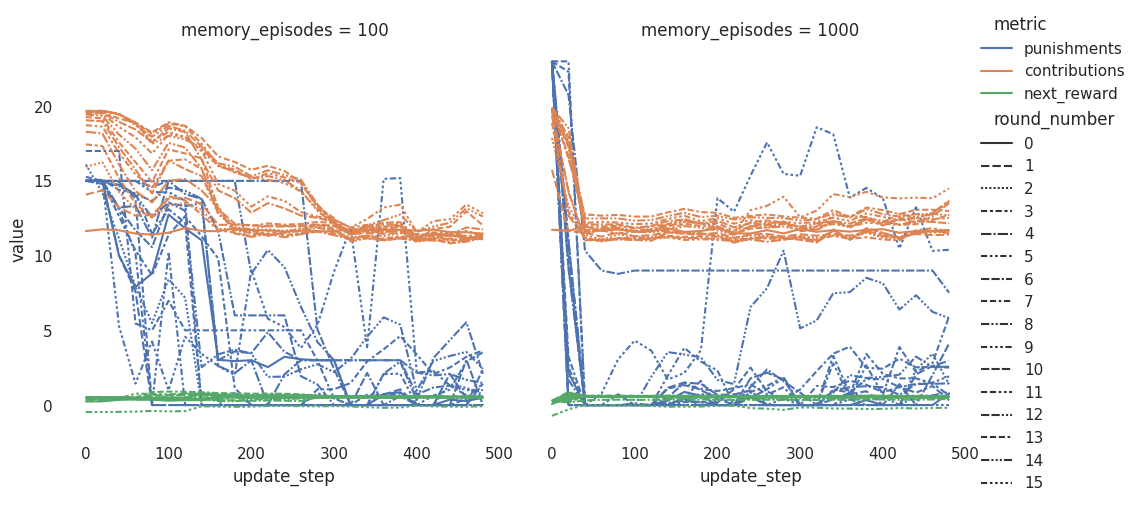

In [89]:
focus = ['update_step', 'metric', 'round_number', 'memory_episodes']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['contributions', 'punishments', 'next_reward'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))


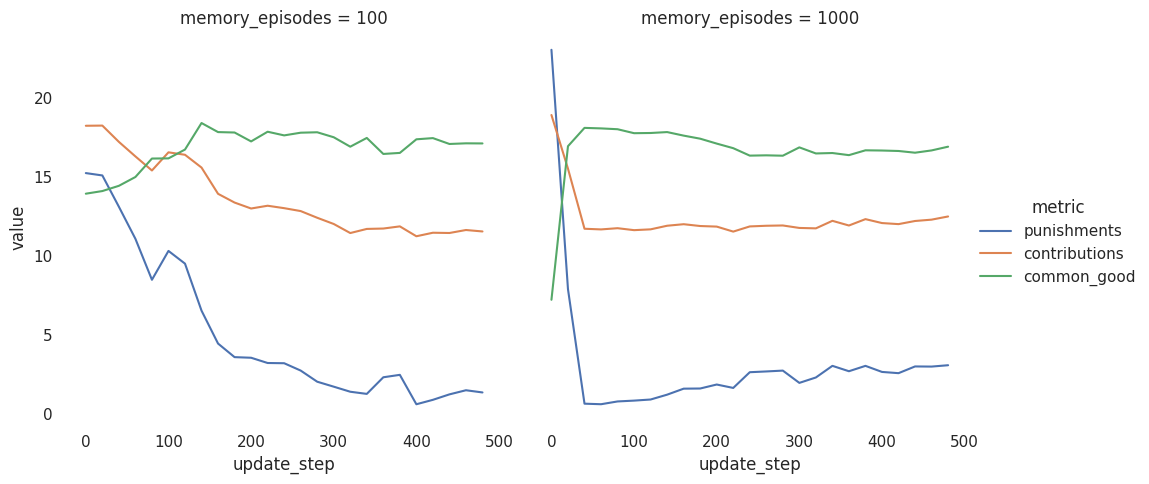

In [90]:
focus = ['update_step', 'metric', 'memory_episodes']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['contributions', 'punishments', 'common_good'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='line', ci=None)

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))

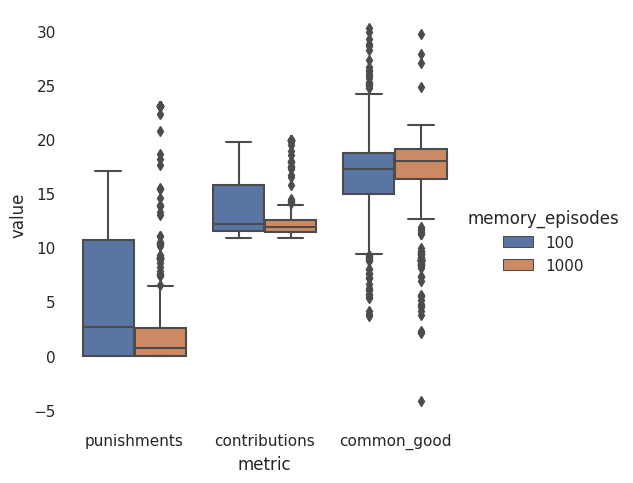

In [91]:
focus = ['metric', 'memory_episodes']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()


# dfs = dfs[dfs['update_step'] > 4000]

w = dfs['metric'].isin(['contributions', 'punishments', 'common_good'])
dfs = dfs[w]


fg = sns.catplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='box', ci=None)

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))

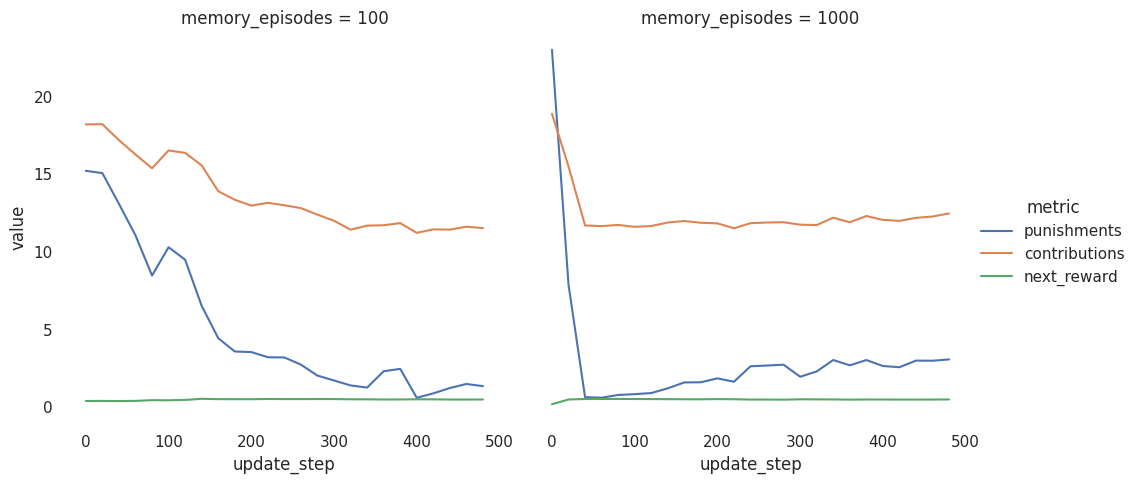

In [92]:
focus = ['update_step', 'metric', 'memory_episodes']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['contributions', 'punishments', 'next_reward'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='line', ci=None)

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))

In [93]:
import os
import torch as th
import numpy as np
import pandas as pd
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.environment_v3 import ArtificialHumanEnv
from aimanager.manager.manager import ArtificalManager

device = th.device('cpu')

n_episodes = 1000

class RuleHuman():
    def __init__(self, contribution):
        self.contribution = contribution

    def encode_pure(self, data, **kwargs):
        return data

    def predict_pure(self, data, **kwargs):
        return th.full_like(data['prev_contributions'], fill_value=self.contribution), 


job_id = df.iloc[0]['job_id']
model_file = os.path.join(model_folder, f'{job_id}.parquet')
rec_keys = ['punishments', 'contributions', 'common_good', 'contributor_payoff', 'manager_payoff']
metric_list = []

for c in range(0,20):
    human_rule_args = {
        'contribution': c
    }

    ah = RuleHuman(**human_rule_args)
    manager = ArtificalManager.load(model_file, device=device)
    env = ArtificialHumanEnv(
        artifical_humans=ah, default_values=manager.default_values, n_agents=4, n_contributions=21, n_punishments=31, batch_size=n_episodes, n_rounds=16, device=device)

    state = env.reset()
    for round_number in count():
        action = manager.get_punishment(**state, **env.get_batch_structure())
        state = env.punish(action)
        
        metrics = {
            k: state[k].to(th.float).mean().item() for k in rec_keys}
        
        metrics = {**metrics, **human_rule_args, 'manager': job_id}

        # pass actions to environment and advance by one step
        state, reward, done = env.step()

        metrics['next_reward'] = reward.mean().item()
        metrics['round_number'] = round_number
        metric_list.append(metrics)
        # break
        if done:
            break




# df.to_parquet(os.path.join(output_path, f'metrics.parquet'))

KeyError: "The following 'value_vars' are not present in the DataFrame: ['job_id', 'memory_episodes', 'metric', 'sampling', 'update_step', 'value']"

In [94]:
id_vars = ['round_number', 'manager'] + list(human_rule_args.keys())

dfm = pd.DataFrame.from_records(metric_list)

value_vars = list(set(dfm.columns) - set(id_vars))
dfm = dfm.melt(id_vars=id_vars, value_vars=value_vars, var_name='metric')

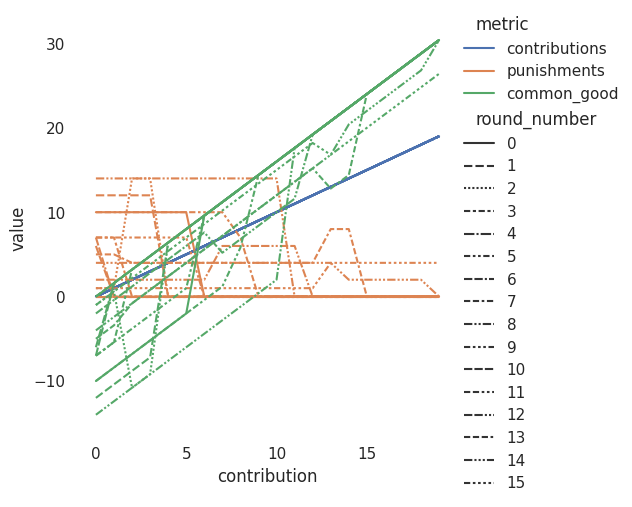

In [102]:
selection = {}

focus = ['contribution', 'metric', 'round_number']

dfs = dfm.copy()

if len(selection):
    w = pd.concat(
        (dfs[k] == v
        for k,v in selection.items() if (k not in focus) and (k in dfs.columns)
        ), axis=1
    ).all(1)
    dfs = dfs[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['contributions', 'punishments', 'common_good'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))